New Price (NASDAQ):
        date       price
0 2025-12-30  23419.0801
1 2025-12-31  23241.9902
2 2026-01-02  23235.6289
3 2026-01-05  23395.8223
4 2026-01-06  23547.1719


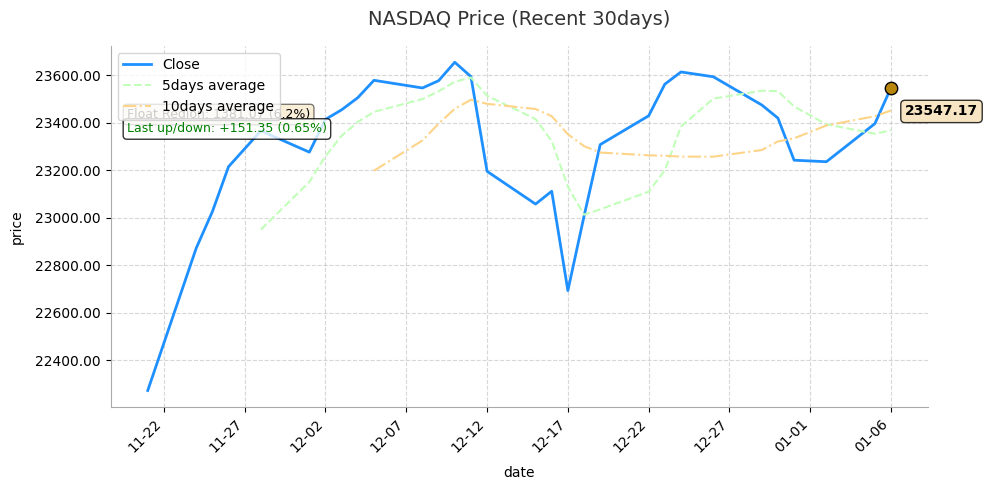


Abstract:
Last New: 23547.17
LDay: +151.35 (+0.65%)
30days highest: 23654.16
30days lowest: 22273.08
5days average: 23367.94
10days average: 23451.11


In [1]:
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import matplotlib.ticker as ticker

# 设置Jupyter图表样式
plt.rcParams['figure.figsize'] = (10, 5)  # 缩小图表大小
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def plot_nasdaq_price_analysis(symbol=".IXIC", days=30):
    """
    获取纳斯达克市场指数数据并绘制价格图，显示价格波动区间和最新涨跌信息。

    参数:
    - symbol: 纳斯达克市场指数代码，默认为 ".IXIC"。
    - days: 显示的天数，默认为 30 天。
    """
    try:
        # 获取纳斯达克市场指数数据
        nasdaq_df = ak.index_us_stock_sina(symbol=symbol)
        
        # 数据清洗和处理
        nasdaq_df = nasdaq_df[['date', 'close']].copy()
        nasdaq_df.columns = ['date', 'price']
        nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])
        nasdaq_df['price'] = pd.to_numeric(nasdaq_df['price'])
        
        # 获取最近指定天数的数据
        end_date = datetime.today()
        start_date = end_date - timedelta(days=days + 15)  # 多取一些数据确保有足够的天数
        recent_nasdaq = nasdaq_df[nasdaq_df['date'] >= start_date].sort_values('date')
        
        # 如果数据不足指定天数，使用所有可用数据
        if len(recent_nasdaq) < days:
            recent_nasdaq = nasdaq_df.sort_values('date').tail(days)
        else:
            recent_nasdaq = recent_nasdaq.tail(days)
            
    except Exception as e:
        print(f"AKShare data get false: {e}")
        # 生成模拟数据作为后备
        dates = pd.date_range(end=datetime.today(), periods=days, freq='D')
        prices = 10000 + 100 * np.sin(np.arange(days)/2 + 0.3 * np.arange(days))
        recent_nasdaq = pd.DataFrame({'date': dates, 'price': prices})

    # 显示最新价格数据
    print("New Price (NASDAQ):")
    print(recent_nasdaq[['date', 'price']].tail(5).reset_index(drop=True))

    # 计算统计指标
    last_price = recent_nasdaq['price'].iloc[-1]
    prev_price = recent_nasdaq['price'].iloc[-2] if len(recent_nasdaq) > 1 else last_price
    daily_change = last_price - prev_price
    daily_change_pct = (daily_change / prev_price) * 100

    # 创建专业金融图表
    fig, ax = plt.subplots(figsize=(10, 5))  # 缩小图表大小

    # 主价格线 - 蓝色
    ax.plot(recent_nasdaq['date'], recent_nasdaq['price'], 
            color="#1E90FF",
            linewidth=2.0,  # 缩小线条宽度
            label='Close')

    # 计算并添加移动平均线
    recent_nasdaq['MA5'] = recent_nasdaq['price'].rolling(window=5).mean()
    recent_nasdaq['MA10'] = recent_nasdaq['price'].rolling(window=10).mean()
    ax.plot(recent_nasdaq['date'], recent_nasdaq['MA5'], 
            color="#C1FFB9",
            linestyle='--', 
            linewidth=1.5,  # 缩小线条宽度
            label='5days average')
    ax.plot(recent_nasdaq['date'], recent_nasdaq['MA10'], 
            color="#FDD488",
            linestyle='-.', 
            linewidth=1.5,  # 缩小线条宽度
            label='10days average')

    # 标记最新价格点
    last_point = recent_nasdaq.iloc[-1]
    ax.scatter(last_point['date'], last_point['price'], 
               s=80,  # 缩小点的大小
               color='#B8860B', edgecolor='black', zorder=10)

    # 最新价格标注
    ax.annotate(f'{last_price:.2f}', 
                (last_point['date'], last_point['price']),
                xytext=(10, -20), 
                textcoords='offset points',
                fontsize=10,  # 缩小字体大小
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

    # 设置标题和标签
    ax.set_title('NASDAQ Price (Recent 30days)', fontsize=14, pad=15, color='#333333')  # 缩小标题字体大小
    ax.set_xlabel('date', fontsize=10, labelpad=8)  # 缩小标签字体大小
    ax.set_ylabel('price', fontsize=10, labelpad=8)  # 缩小标签字体大小

    # 日期格式化
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    fig.autofmt_xdate(rotation=45)

    # 价格格式化
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))

    # 添加网格
    ax.grid(True, linestyle='--', alpha=0.5)

    # 添加图例
    ax.legend(loc='upper left', frameon=True, framealpha=0.8, fontsize=10)  # 缩小图例字体大小

    # 添加价格区间信息
    price_range = recent_nasdaq['price'].max() - recent_nasdaq['price'].min()
    ax.text(0.02, 0.8, 
            f'Float Region: {price_range:.2f} ({price_range/recent_nasdaq["price"].iloc[0]*100:.1f}%)',
            transform=ax.transAxes,
            fontsize=9,  # 缩小字体大小
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # 添加涨跌信息
    change_color = 'red' if daily_change < 0 else 'green'
    ax.text(0.02, 0.76, 
            f'Last up/down: {"+" if daily_change >= 0 else ""}{daily_change:.2f} ({daily_change_pct:.2f}%)',
            transform=ax.transAxes,
            fontsize=9,  # 缩小字体大小
            color=change_color,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 优化图表边框
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_color('#AAAAAA')
        ax.spines[spine].set_linewidth(0.8)

    plt.tight_layout()
    plt.show()

    # 显示统计摘要
    print("\nAbstract:")
    print(f"Last New: {last_price:.2f}")
    print(f"LDay: {'+' if daily_change >= 0 else ''}{daily_change:.2f} ({daily_change_pct:+.2f}%)")
    print(f"30days highest: {recent_nasdaq['price'].max():.2f}")
    print(f"30days lowest: {recent_nasdaq['price'].min():.2f}")
    print(f"5days average: {recent_nasdaq['MA5'].iloc[-1]:.2f}")
    print(f"10days average: {recent_nasdaq['MA10'].iloc[-1]:.2f}")

# 调用函数
plot_nasdaq_price_analysis(symbol=".IXIC", days=30)

Recent Volume (NASDAQ):
        date      volume
0 2025-12-30  5963151921
1 2025-12-31  5084105331
2 2026-01-02  6021371879
3 2026-01-05  7477362463
4 2026-01-06  7130168642


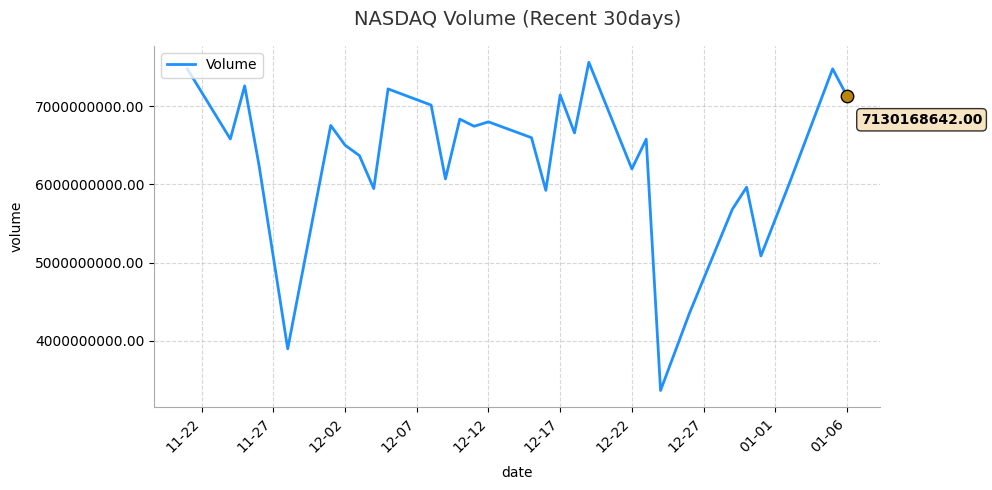

Data saved to nasdaq_volume_30_days.csv


In [2]:
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import matplotlib.ticker as ticker

# 设置Jupyter图表样式
plt.rcParams['figure.figsize'] = (10, 5)  # 缩小图表大小
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

def plot_nasdaq_volume_analysis(symbol=".IXIC", days=30):
    """
    获取纳斯达克市场指数数据并绘制交易量曲线图，显示交易量波动区间和最新交易量信息。

    参数:
    - symbol: 纳斯达克市场指数代码，默认为 ".IXIC"。
    - days: 显示的天数，默认为 30 天。
    """
    try:
        # 获取纳斯达克市场指数数据
        nasdaq_df = ak.index_us_stock_sina(symbol=symbol)
        
        # 数据清洗和处理
        nasdaq_df = nasdaq_df[['date', 'volume']].copy()
        nasdaq_df.columns = ['date', 'volume']
        nasdaq_df['date'] = pd.to_datetime(nasdaq_df['date'])
        nasdaq_df['volume'] = pd.to_numeric(nasdaq_df['volume'], errors='coerce')
        
        # 填充空值为0
        nasdaq_df.fillna(0, inplace=True)
        
        # 获取最近指定天数的数据
        end_date = datetime.today()
        start_date = end_date - timedelta(days=days + 15)  # 多取一些数据确保有足够的天数
        recent_nasdaq = nasdaq_df[nasdaq_df['date'] >= start_date].sort_values('date')
        
        # 如果数据不足指定天数，使用所有可用数据
        if len(recent_nasdaq) < days:
            recent_nasdaq = nasdaq_df.sort_values('date').tail(days)
        else:
            recent_nasdaq = recent_nasdaq.tail(days)
            
    except Exception as e:
        print(f"AKShare data get false: {e}")
        # 生成模拟数据作为后备
        dates = pd.date_range(end=datetime.today(), periods=days, freq='D')
        volumes = 1000000 + 100000 * np.sin(np.arange(days)/2 + 0.3 * np.arange(days))
        recent_nasdaq = pd.DataFrame({'date': dates, 'volume': volumes})

    # 显示最新交易量数据
    print("Recent Volume (NASDAQ):")
    print(recent_nasdaq[['date', 'volume']].tail(5).reset_index(drop=True))

    # 绘制交易量曲线图
    fig, ax = plt.subplots(figsize=(10, 5))  # 缩小图表大小

    # 主交易量线 - 蓝色
    ax.plot(recent_nasdaq['date'], recent_nasdaq['volume'], 
            color="#1E90FF",
            linewidth=2.0,  # 缩小线条宽度
            label='Volume')

    # 标记最新交易量点
    last_point = recent_nasdaq.iloc[-1]
    ax.scatter(last_point['date'], last_point['volume'], 
               s=80,  # 缩小点的大小
               color='#B8860B', edgecolor='black', zorder=10)

    # 最新交易量标注
    ax.annotate(f'{last_point["volume"]:.2f}', 
                (last_point['date'], last_point['volume']),
                xytext=(10, -20), 
                textcoords='offset points',
                fontsize=10,  # 缩小字体大小
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='wheat', alpha=0.8))

    # 设置标题和标签
    ax.set_title('NASDAQ Volume (Recent 30days)', fontsize=14, pad=15, color='#333333')  # 缩小标题字体大小
    ax.set_xlabel('date', fontsize=10, labelpad=8)  # 缩小标签字体大小
    ax.set_ylabel('volume', fontsize=10, labelpad=8)  # 缩小标签字体大小

    # 日期格式化
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    fig.autofmt_xdate(rotation=45)

    # 交易量格式化
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x:.2f}'))

    # 添加网格
    ax.grid(True, linestyle='--', alpha=0.5)

    # 添加图例
    ax.legend(loc='upper left', frameon=True, framealpha=0.8, fontsize=10)  # 缩小图例字体大小

    # 优化图表边框
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['bottom', 'left']:
        ax.spines[spine].set_color('#AAAAAA')
        ax.spines[spine].set_linewidth(0.8)

    plt.tight_layout()
    plt.show()

    # 保存数据到CSV文件
    csv_filename = f"nasdaq_volume_{days}_days.csv"
    recent_nasdaq.to_csv(csv_filename, index=False, encoding='utf-8-sig')
    print(f"Data saved to {csv_filename}")

# 调用函数
plot_nasdaq_volume_analysis(symbol=".IXIC", days=30)